# Data Preparation - Creating Working Dataframe
In this notebook we will merge our many data sources into a "working" dataframe for EDA, etc.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Team Records
- Need year n-1 to predict year n

In [60]:
# Get records for teams
records_df = pd.read_csv('./data/records_by_year_calcs.csv')

# Sort by team and year
records_df = records_df.sort_values(by=['team', 'year'])

# Shift recent_win_pct by +1 years
records_df['recent_win_pct'] = records_df.groupby('team')['recent_win_pct'].shift(1)
records_df['prev_win_pct'] = records_df.groupby('team')['win_pct'].shift(1)

# Keep only records from 2014
records_2014_df = records_df[records_df['year'] >= 2014].copy()

records_df.head()

,team,year,conference,expected_wins,win_pct,recent_win_pct,prev_win_pct
0,Air Force,2000,Mountain West,0.0,0.750000,NaN,NaN
115,Air Force,2001,Mountain West,0.0,0.500000,0.750000,0.750000
231,Air Force,2002,Mountain West,0.0,0.615385,0.625000,0.500000
347,Air Force,2003,Mountain West,0.0,0.583333,0.621622,0.615385
463,Air Force,2004,Mountain West,0.0,0.454545,0.612245,0.583333


### Recruiting Information
- Need year n to predict year n

In [61]:
# Get recruiting info
recruiting_df = pd.read_csv('./data/team_recruiting_w_blue_chip_ratios.csv')

# Filter the years we need
recruiting_2014_df = recruiting_df[recruiting_df.year >= 2014].copy()

# Remove/rename some columns
recruiting_2014_df = recruiting_2014_df.drop(columns=['total', 'blue_sums', 'total_sums'])
recruiting_2014_df = recruiting_2014_df.rename(columns={'rank': 'recruiting_rank', 'points': 'recruiting_rating'})
recruiting_2014_df.head()

,team,year,recruiting_rank,recruiting_rating,talent_level,blue_chip,blue_chip_ratio
510,Alabama,2014,1,319.71,312.7075,20.0,0.755319
511,LSU,2014,2,299.29,276.3850,16.0,0.659341
512,Ohio State,2014,3,296.08,291.0075,16.0,0.673684
513,Florida State,2014,4,286.79,284.1550,15.0,0.586957
514,Texas A&M,2014,5,278.08,246.9850,12.0,0.459770


### Returning Talent
- Need year n to predict year n
- Note that we don't need the conference here also some of the conferences aren't updated
- ex. Maryland is listed in 2014 as being in ACC, but they moved to the Big Ten for the 2014-2015 season

In [62]:
returning_2014_df = pd.read_csv('data/returning_players_2014.csv')
returning_2014_df = returning_2014_df.drop(columns=['conference'])
returning_2014_df

,year,team,passing_usage,rushing_usage,usages
0,2014,Air Force,0.751,0.652,0.684
1,2014,Akron,1.000,0.989,0.952
2,2014,Alabama,0.078,0.911,0.589
3,2014,Arizona,0.000,0.048,0.142
4,2014,Arizona State,0.990,0.562,0.713
...,...,...,...,...,...
1282,2023,Western Kentucky,0.498,0.548,0.513
1283,2023,Western Michigan,0.994,0.335,0.605
1284,2023,West Virginia,0.212,0.639,0.362
1285,2023,Wisconsin,0.052,0.748,0.493


### ELO/FPI Ratings
- Need year n-1 to predict year n
- We will ADD 1 to each year so that each one represents the ELO rating at the START of each year.
- These ratings are at the END of each year. For example, Notre Dame's peaks in 2012 when they went to the national championship game.
- Another example is South Carolina, which peaks at the END of 2013, the last season they were good

In [63]:
ratings_df = pd.read_csv('data/team_conference_ratings.csv')

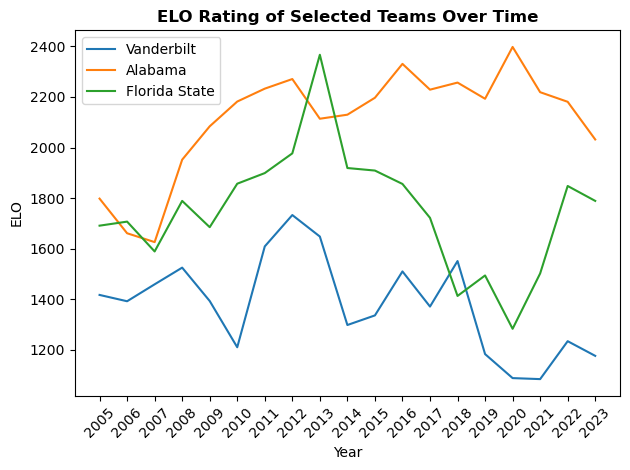

In [64]:
# Plotting ELO Ratings
teams = ['Vanderbilt', 'Alabama', 'Florida State']
for team in teams:
    sns.lineplot(x=ratings_df[ratings_df.team == team].year, 
                 y= ratings_df[ratings_df.team == team].elo,
                 label = team)
plt.title(f'ELO Rating of Selected Teams Over Time', fontweight='bold')
plt.xlabel('Year')
plt.ylabel("ELO")
plt.legend()
plt.xticks(ratings_df.year.unique(), rotation=45)
plt.tight_layout()
plt.savefig('images/elo-ratings-over-time.png')
plt.show()

In [65]:
# Grab data going back to 2013, 1 year before starting analysis
ratings_2014_df = ratings_df[ratings_df.year >= 2013].copy()

# Relabel years by +1 so they are rating at start of new season
ratings_2014_df['year'] = ratings_2014_df['year'] + 1

ratings_2014_df.head()

,team,year,conference,elo,fpi,conference_rating
875,Air Force,2014,Mountain West,1071.0,-16.682,-5.908333
876,Akron,2014,Mid-American,1121.0,-12.121,-12.792308
877,Alabama,2014,SEC,2114.0,28.891,15.450000
878,Arizona,2014,Pac-12,1652.0,13.168,14.000000
879,Arizona State,2014,Pac-12,1823.0,21.855,14.000000


### Last Season Traditional Stats
- Need year n-1 to predict year n
- Need to relabel by adding 1 to each year. Drop the conference column for now
- KEEP: turnover margin, total yards, total tds
- Note: In 2020, several teams did not play and have NaN for yards/turnover margin, etc. We'll fill with 0's.

In [66]:
trad_stats_df = pd.read_csv('data/season_stats_w_totals.csv')[['year', 'team', 'totalYards', 'turnover_margin', 'total_tds', 'games']]

# Switch year by 1 so we're using last season's stats
trad_stats_df['year'] = trad_stats_df['year'] + 1

# Fix NaN values
trad_stats_df = trad_stats_df.fillna(0)

# Keep from 2014 on (AFTER relabel)
trad_stats_df = trad_stats_df[trad_stats_df['year'] >= 2014]

trad_stats_df.head()

,year,team,totalYards,turnover_margin,total_tds,games
6,2014,Air Force,4411.0,-4.0,38.0,12.0
7,2015,Air Force,5443.0,1.0,50.0,13.0
8,2016,Air Force,6315.0,-5.0,60.0,14.0
9,2017,Air Force,5878.0,6.0,53.0,13.0
10,2018,Air Force,5004.0,-11.0,48.0,12.0


### Last Season Advanced Stats
- Need year n-1 to predict year n
- Perform relabeling here so that advanced stats are from LAST season. Add 1 to each year
- Drop the conference column here as well as there are some years where the conference was not updated after a switch was made

In [67]:
adv_stats_df = pd.read_csv('data/advanced_stats_seasons.csv')

# Switch names of a few categories and drop uneeded columns
adv_stats_df = adv_stats_df.rename(columns={'season': 'year'})
adv_stats_df = adv_stats_df.drop(columns=['offense', 'defense', 'conference'])

# Switch year by 1 so we're getting last seasons stats
adv_stats_df['year'] = adv_stats_df['year'] + 1

# Filter data from 2014 - 2023 (10 years of data)
adv_stats_2014_df = adv_stats_df[adv_stats_df['year'] >= 2014].copy()
adv_stats_2014_df.head()

,year,team,off_drives,def_drives,off_explode,def_explode,off_ppa,def_ppa,off_success_rate,def_success_rate
12,2014,Air Force,139,137,0.860561,0.902638,0.096601,0.214295,0.439644,0.518913
13,2015,Air Force,165,161,1.089935,1.425767,0.207059,0.138795,0.451837,0.375831
14,2016,Air Force,177,173,1.154045,1.549206,0.272449,0.172654,0.474216,0.357631
15,2017,Air Force,147,148,1.027586,1.534094,0.227697,0.158770,0.483333,0.366048
16,2018,Air Force,138,139,1.095699,1.374592,0.235542,0.247661,0.488398,0.422096


### Strength of Schedule
- Need year n to predict year n for strength of schedule
- Need year n-1 to predict year n for strength of record
- We grab the year, team, sor (Strength of Record), and sos (Strength of Schedule)
- Be careful with strength of record as this may take into account the current season

In [68]:
sos_df = pd.read_csv('data/schedule_strength.csv')

# Shift strength of record column to add 1 year so year n-1 predicts year n
sos_df['sor'] = sos_df.groupby('team')['sor'].shift(1)
sos_df[sos_df.team == 'South Carolina'].head()

,year,team,sor,sos
31,2005,South Carolina,NaN,28
151,2006,South Carolina,32.0,29
279,2007,South Carolina,33.0,14
394,2008,South Carolina,42.0,13
510,2009,South Carolina,38.0,10


### Coaching Information
- Need coach in year n but career win percentage from year n-1. 
- Need to shift all win percentages forward by 1

In [69]:
coaches_df = pd.read_csv('data/coach_career_win_pct.csv')
coaches_df = coaches_df.rename(columns={'name': 'coach'})
coaches_df.head()

,coach,team,year,games,wins,losses,cumulative_wins,cumulative_games,career_win_pct
0,Frank Mason,Harvard,1886,14,12,2,12,14,0.857143
1,Walter Camp,Yale,1888,13,13,0,13,13,1.000000
2,Walter Camp,Yale,1889,17,16,1,29,30,0.966667
3,Walter Camp,Yale,1890,14,13,1,42,44,0.954545
4,Alexander Lilley,Ohio State,1890,4,1,3,1,4,0.250000


In [70]:
# Shift coaching carrer_win_pct to add 1  year so year n-1 predicts year n
coaches_df['career_win_pct'] = coaches_df.groupby('coach')['career_win_pct'].shift(1)
coaches_df['career_win_pct'] = coaches_df['career_win_pct'].fillna(0)

# Keep only a couple of columns
coaches_df = coaches_df[['coach', 'team', 'year', 'career_win_pct']].copy()
coaches_df[coaches_df.coach == 'Lane Kiffin']

,coach,team,year,career_win_pct
10109,Lane Kiffin,Tennessee,2009,0.000000
10338,Lane Kiffin,USC,2010,0.538462
10422,Lane Kiffin,USC,2011,0.576923
10531,Lane Kiffin,USC,2012,0.657895
10630,Lane Kiffin,USC,2013,0.627451
11176,Lane Kiffin,Florida Atlantic,2017,0.625000
11319,Lane Kiffin,Florida Atlantic,2018,0.657143
11469,Lane Kiffin,Florida Atlantic,2019,0.621951
11669,Lane Kiffin,Ole Miss,2020,0.645833
11745,Lane Kiffin,Ole Miss,2021,0.632075


### Combine Features
1. records_2014_df
2. recruiting_2014_df
3. returning_2014_df
4. ratings_2014_df
5. trad_stats_df
6. adv_stats_2014_df
7. sos_df
8. coaches_df

In [71]:
df = records_2014_df.merge(ratings_2014_df, on=['year', 'team', 'conference']) \
                        .merge(recruiting_2014_df, on=['year', 'team']) \
                        .merge(returning_2014_df, on=['year', 'team']) \
                        .merge(trad_stats_df, on=['year', 'team']) \
                        .merge(adv_stats_2014_df, on=['year', 'team']) \
                        .merge(coaches_df, on=['year', 'team']) \
                        .merge(sos_df, on=['year', 'team'])
df.head()

,team,year,conference,expected_wins,win_pct,recent_win_pct,prev_win_pct,elo,fpi,conference_rating,...,off_explode,def_explode,off_ppa,def_ppa,off_success_rate,def_success_rate,coach,career_win_pct,sor,sos
0,Air Force,2014,Mountain West,9.7,0.769231,0.531792,0.166667,1071.0,-16.682,-5.908333,...,0.860561,0.902638,0.096601,0.214295,0.439644,0.518913,Troy Calhoun,0.544444,115.0,113
1,Air Force,2015,Mountain West,8.2,0.571429,0.548387,0.769231,1432.0,-2.584,-5.466667,...,1.089935,1.425767,0.207059,0.138795,0.451837,0.375831,Troy Calhoun,0.572816,48.0,86
2,Air Force,2016,Mountain West,9.4,0.769231,0.550000,0.571429,1533.0,1.846,-4.766667,...,1.154045,1.549206,0.272449,0.172654,0.474216,0.357631,Troy Calhoun,0.572650,71.0,113
3,Air Force,2017,Mountain West,4.4,0.416667,0.563380,0.769231,1593.0,0.881,-4.683333,...,1.027586,1.534094,0.227697,0.158770,0.483333,0.366048,Troy Calhoun,0.592308,49.0,82
4,Air Force,2018,Mountain West,6.4,0.416667,0.555556,0.416667,1422.0,-6.875,-7.083333,...,1.095699,1.374592,0.235542,0.247661,0.488398,0.422096,Troy Calhoun,0.577465,94.0,86


In [72]:
df.columns

Index(['team', 'year', 'conference', 'expected_wins', 'win_pct',
       'recent_win_pct', 'prev_win_pct', 'elo', 'fpi', 'conference_rating',
       'recruiting_rank', 'recruiting_rating', 'talent_level', 'blue_chip',
       'blue_chip_ratio', 'passing_usage', 'rushing_usage', 'usages',
       'totalYards', 'turnover_margin', 'total_tds', 'games', 'off_drives',
       'def_drives', 'off_explode', 'def_explode', 'off_ppa', 'def_ppa',
       'off_success_rate', 'def_success_rate', 'coach', 'career_win_pct',
       'sor', 'sos'],
      dtype='object')

In [73]:
# Save this dataframe as the "working dataframe" for later use
df.to_csv('data/working_df.csv', index=False)